## Tensorflow 1.4

In the first step I implemented tensorflow a simple cnn using tf 1.4  

In [1]:
from cnn_utils import *
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
x_train, y_train, x_test, y_test, classes = load_dataset()

In [3]:
x_train.shape, y_train.shape, x_test.shape, classes.shape

((1080, 64, 64, 3), (1, 1080), (120, 64, 64, 3), (6,))

y=4


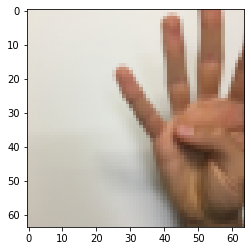

In [4]:
idx = 320
plt.imshow(x_train[idx])
print('y={}'.format(y_train[0][idx]))

In [5]:
x_train, x_test = x_train/255, x_test/255

# build one-hot labels
y_train = np.array(list(map(lambda x: np.eye(len(classes))[int(x[0])], y_train.T)))
y_test = np.array(list(map(lambda x: np.eye(len(classes))[int(x[0])], y_test.T)))

In [6]:
y_test.shape, y_train.shape

((120, 6), (1080, 6))

In [7]:
def forward_propagation(X, params):
    W1, W2 = params['w1'], params['w2']
    
    Z1 = tf.nn.conv2d(X, W1, strides=[1], padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[8], strides=[8], padding='SAME')
    Z2 = tf.nn.conv2d(P1, W2, strides=[1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[4], strides=[4], padding='SAME')
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)
    
    return Z3


def comp_loss(Y, labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits
                          (logits=Y, labels=labels))


In [8]:
forward_propagation(X, params)

NameError: name 'X' is not defined

In [9]:
def random_mini_batch(X, Y, bs):
    permutation = list(np.random.permutation(X.shape[0]))
    shuffled_x, shuffled_y = X[permutation,:,:,:], Y[permutation,:]
    
    batches = []
    for k in range(X.shape[0]//bs):
        mini_batch_x = shuffled_x[k*bs:(k+1)*bs,:,:,:]
        mini_batch_y = shuffled_y[k*bs:(k+1)*bs,:]
        batches.append((mini_batch_x, mini_batch_y))
    return batches


In [68]:
costs = []
epochs = 100
with tf.device('/cpu:0'):
    bs = 10
    
    ops.reset_default_graph()

    X = tf.placeholder(tf.float32, name='X', shape=(None, 64, 64, 3))
    Y = tf.placeholder(tf.float32, name='Y', shape=[None, 6])

    with tf.variable_scope('declaration', reuse=tf.AUTO_REUSE):
        w1 = tf.get_variable('w1', shape=(4,4,3,8), initializer=tf.contrib.layers.xavier_initializer())
        w2 = tf.get_variable('w2', shape=(2,2,8,16), initializer=tf.contrib.layers.xavier_initializer())
        params = {'w1': w1, 'w2': w2}

    output = forward_propagation(X, params)
    loss = comp_loss(output, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.005).minimize(loss)

    init = tf.global_variables_initializer()

    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(epochs):
            batch_loss = 0
            num_batches = x_train.shape[0]//bs
            batches = random_mini_batch(x_train, y_train, bs)

            for x,y in batches:
                _, bloss = sess.run([optimizer, loss], feed_dict={X: x, Y: y})
                batch_loss += bloss / num_batches

            print("loss in epoch {} is : {}".format(epoch, batch_loss))
            saver.save(sess, './sessoin-tmp.cptk')
            

loss in epoch 0 is : 1.8005127796420335
loss in epoch 1 is : 1.7930649309246636
loss in epoch 2 is : 1.7661988911805335
loss in epoch 3 is : 1.6462532513671442
loss in epoch 4 is : 1.5614957676993475
loss in epoch 5 is : 1.4927244467867742
loss in epoch 6 is : 1.4378787130117414
loss in epoch 7 is : 1.3968878206279542
loss in epoch 8 is : 1.358100961755824
loss in epoch 9 is : 1.3009367303715809
loss in epoch 10 is : 1.305431502560775
loss in epoch 11 is : 1.2417951860913525
loss in epoch 12 is : 1.1913069414871718
loss in epoch 13 is : 1.1731864175310847
loss in epoch 14 is : 1.1333575866840506
loss in epoch 15 is : 1.1299971916057443
loss in epoch 16 is : 1.1062404248449533
loss in epoch 17 is : 1.084407552524849
loss in epoch 18 is : 1.0529624963248219
loss in epoch 19 is : 1.0510739968330767
loss in epoch 20 is : 1.0249129434426627
loss in epoch 21 is : 1.0180492569450974
loss in epoch 22 is : 1.010941124348729
loss in epoch 23 is : 0.9855264411480338
loss in epoch 24 is : 1.000442

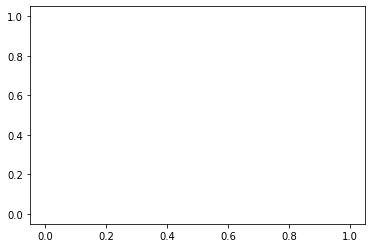

In [41]:
plt.plot(costs)

train_acc: 0.8009259104728699 test_acc: 0.7166666388511658


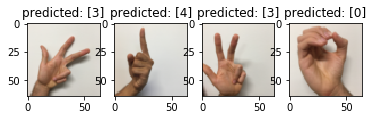

In [74]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess,  './sessoin-tmp.cptk')
    
    correct = tf.equal(tf.arg_max(Y,1), tf.arg_max(output,1))
    _acc = tf.reduce_mean(tf.cast(correct, tf.float32))
    train_acc = _acc.eval({X:x_train, Y:y_train})
    test_acc = _acc.eval({X:x_test, Y:y_test})
    
    print("train_acc: {} test_acc: {}".format(train_acc, test_acc))
    
    idx = 12
    
    fig = plt.figure()
    tests = [12, 14, 30, 40]
    for idx, i in enumerate(tests):
        chosen_x = np.array([x_test[i,:,:,:]])
        predicted = tf.arg_max(output, dimension=1)
        res = sess.run([predicted], feed_dict={X:chosen_x})
        
        plt.subplot(1, len(tests), idx+1)
        plt.title("predicted: {}".format(res[0]))
        plt.imshow(x_test[i])
    

## Tensorflow 2.0

In this step i'm gonna implement previous model using keras in tf 2.0

In [51]:
import tensorflow as tf

tf.__version__
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [52]:
from cnn_utils import *

x_train, y_train, x_test, y_test, classes = load_dataset()
batch_size = 25

x_train = x_train / 255
x_test = x_test / 255

y_train = y_train.T
y_test = y_test.T


In [53]:
# batching and shuffling dataset
# initial dimentions should match

train_ds = tf.data.Dataset.from_tensor_slices(
(x_train, y_train)).shuffle(1000).batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices(
(x_test, y_test)).batch(batch_size)

print(train_ds, test_ds)

<BatchDataset shapes: ((None, 64, 64, 3), (None, 1)), types: (tf.float64, tf.int64)> <BatchDataset shapes: ((None, 64, 64, 3), (None, 1)), types: (tf.float64, tf.int64)>


In [54]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D


class CnnModel(Model):
    def __init__(self):
        super(CnnModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(6, activation='softmax')
    
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

model = CnnModel()
    

In [55]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_acc')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_acc')

In [56]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        pred = model(images)
        t_loss = loss(labels, pred)
    gradients = tape.gradient(t_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(t_loss)
    train_acc(labels, pred)




In [57]:
@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss(labels, predictions)

  test_loss(t_loss)
  test_acc(labels, predictions)

In [58]:
epochs = 20

for epoch in range(epochs):
    for images, labels in train_ds:
        train_step(images, labels)

    for images, labels in test_ds:
        test_step(images, labels)

    print('Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'.format(
        epoch + 1,
        train_loss.result(),
        train_acc.result(),
        test_loss.result(),
        test_acc.result()
    ))

Epoch 1, Loss: 3.659438133239746, Accuracy: 0.27222222089767456, Test Loss: 1.4499263763427734, Test Accuracy: 0.4833333194255829
Epoch 2, Loss: 2.3691024780273438, Accuracy: 0.45601850748062134, Test Loss: 1.3363101482391357, Test Accuracy: 0.5291666388511658
Epoch 3, Loss: 1.7994730472564697, Accuracy: 0.5666666626930237, Test Loss: 1.1130446195602417, Test Accuracy: 0.6194444298744202
Epoch 4, Loss: 1.4549657106399536, Accuracy: 0.6462963223457336, Test Loss: 0.9793480038642883, Test Accuracy: 0.6666666865348816
Epoch 5, Loss: 1.2243974208831787, Accuracy: 0.7035185098648071, Test Loss: 0.8764980435371399, Test Accuracy: 0.7066666483879089
Epoch 6, Loss: 1.0563997030258179, Accuracy: 0.7466049194335938, Test Loss: 0.809787929058075, Test Accuracy: 0.730555534362793
Epoch 7, Loss: 0.9264386892318726, Accuracy: 0.7806878089904785, Test Loss: 0.750576376914978, Test Accuracy: 0.7547619342803955
Epoch 8, Loss: 0.823894739151001, Accuracy: 0.8068286776542664, Test Loss: 0.701711654663085